In [1]:
import numpy as np
import pandas as pd
from time import time
import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

In [2]:
FIRST_SIZE = 2
LAST_SIZE = 32

COUNT_TRIES = 100

MAX_DEF_COUNT_ITER = 100000
"""Максимальное количество итераций по-умолчанию"""
DEF_EPS = 0.00001
"""Точность по-умолчанию"""

'Точность по-умолчанию'

In [3]:
df = pd.DataFrame(
    columns=[
        "size",
        "true_value_max",
        "true_value_min",
        "value_max",
        "value_max_time",
        "value_min_def",
        "value_min_def_time",
        # "value_min_rel",
        # "value_min_rel_time"
    ],
    index=range(1, (LAST_SIZE - FIRST_SIZE + 1) * COUNT_TRIES + 1),
)
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3097,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3098,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3099,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Подготовка

In [4]:
def calc(A: np.matrix, b: np.matrix) -> np.matrix:
    if b is None:
        print("Вектор собственного значения не был посчитан")
        return None
    return float((b.T @ A @ b) / (b.T @ b))

In [5]:
def output(
    A: np.matrix,
    texts: list[str],
    funcs: list,

    num_iterrations: int = MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
    mu: float = None,
) -> tuple[np.matrix, list[float | None]]:

    abs_v = np.abs(np.linalg.eigvals(A))

    abs_v_max = np.max(abs_v)

    abs_v_min = np.min(abs_v)
    # print(

    #     "Собственные значения матрицы A",

    #     f"Максимальное: {abs_v_max}",
    #     f"Минимальное: {abs_v_min}",
    #     sep="\n",
    # )


    # print("========")

    mass_eval = []


    for text, f in zip(texts, funcs):
        start_time = time()
        # print(text)
        if f.__name__ != inverse_power_rel.__name__:
            evec, eval = f(A=A, num_iterations=num_iterrations, b_k=b_k)
            # evec = f(A=A, num_iterations=num_iterrations, b_k=b_k)
            # eval = calc(A, evec)
        else:
            evec, eval = f(A=A, b_k=b_k, mu=mu)
        stop_time = time()
        # print("========")
        mass_eval.append(abs(eval))
        mass_eval.append(stop_time - start_time)


    # print(text_1)

    # first_evec = f_1(A=A, num_iterations=num_iterrations, b_k=b_k)

    # first_eval = calc(A, first_evec)
    # print("========")


    # print(text_2)

    # if f_2.__name__ != inverse_power_rel.__name__:

    #     second_evec = f_2(A=A, num_iterations=num_iterrations, b_k=b_k)

    #     second_eval = calc(A, second_evec)

    # else:

    #     second_evec, second_eval = f_2(A=A, b_k=b_k, mu=mu)
    # print("========")

    # print(


    #     "Собственные векторы:",

    #     f"{text_1}:",
    #     first_evec,


    #     f"{text_2}:",

    #     second_evec,

    #     sep="\n",
    # )
    # print(


    #     "Собственные значения:",

    #     f"{text_1}: {first_eval}",

    #     f"{text_2}: {second_eval}",

    #     sep="\n",
    # )


    return A.shape[0], abs_v_max, abs_v_min, *mass_eval

# Прямой метод

$x^{(k)} = \dfrac{Ax^{(k - 1)}}{\alpha_{k - 1}}$

$\lambda_{1}(A) = \dfrac{\left( Ax^{(k)}, x^{(k)} \right)}{(x^{(k)}, x^{(k)})} = \dfrac{(x^{(k)})^{T}A^{(k)}x^{(k)}}{(x^{(k)})^{T}x^{(k)}}$, где $|\lambda_1(A)|$ - наибольшее по модулю СЗ

In [6]:
def power_iteration(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> np.matrix:
    if b_k is None:
        b_k = np.random.rand(A.shape[1], 1)
    # print("Начальное приближение:", b_k, sep="\n")

    alpha_old = None

    for _ in range(num_iterations):
        b_k1 = np.dot(A, b_k)

        b_k1_norm = np.linalg.norm(b_k1)

        b_k = b_k1 / b_k1_norm

        alpha_new = calc(A, b_k)
        if alpha_old is not None and abs(alpha_new - alpha_old) < epsilon:
            break
        alpha_old = alpha_new

    return b_k, alpha_new

# Обратный метод

## Стандартная версия

In [7]:
def inverse_power_def(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> np.matrix:
    try:
        inv_A = np.linalg.inv(A)
    except np.linalg.LinAlgError:
        print("Вырожденная матрица")
        return None
    # print("Обратная матрица:",inv_A, sep="\n")
    res = power_iteration(
        inv_A, epsilon=epsilon, num_iterations=num_iterations, b_k=b_k
    )
    return res[0], 1 / res[1]

In [8]:
# A: np.matrix = np.matrix("1 3 -2 0;"
#                          "1 1 4 7;"
#                          "4 7 11 23;"
#                          "52 66 2 0")  # -0.65
# calc(A, inverse_power_def(A))

## Модификация Релэя

In [9]:
import random


def inverse_power_rel(A, epsilon: float = DEF_EPS, num_iterations = MAX_DEF_COUNT_ITER, mu = None, b_k = None):
  if b_k is None:
      b_k = np.random.rand(A.shape[1], 1) # Попробовать близкий к настоящему собственный вектор
  if mu is None:
    mu = random.randint(1, 19) / 10 # Случайное начальное приближение
  print("Начальное приближение:", "СЗ:", mu, "СВ:", b_k, sep="\n")
  
  b_k = b_k / np.linalg.norm(b_k)
  y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
  # print(y)
  # print(x)
  lambda_ = float(np.dot(y.T, b_k))
  # print(lambda_, lambda_ * x)
  mu = mu + 1 / lambda_
  err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)
  
  index = 0
  while err > epsilon or index < num_iterations:
    b_k = y / np.linalg.norm(y)
    y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
    lambda_ = float(np.dot(y.T, b_k))
    mu = mu + 1 / lambda_
    err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)
    index += 1

  return b_k, float(mu)


In [10]:
A: np.matrix = np.matrix("1 -2 -1;"
                         "-1 1 1;"
                         "1 0 -1")  # 0, 2, -1
# Сильно зависит от начального приближения
# Не вижу в ней смысла
# A, calc(A, power_iteration(A, 1000)), inverse_power_rel(A, 0.0001)[1]
# calc(A, inverse_power_rel(A)[0])

In [11]:
def generate_non_singular(n):
    while True:
        # Генерируем случайную матрицу n x n
        matrix = np.random.rand(n, n)  # Вы можете использовать np.random.randint для целых чисел.
        if np.linalg.det(matrix) != 0:  # Проверяем, что определитель не равен нулю
            return matrix

In [12]:
import numpy as np
# texts = ["Прямые итерации", "Обратные итерации (обычные)", "Обратные итерации (Релэя)"]
# funcs = [power_iteration, inverse_power_def, inverse_power_rel]
texts = ["Прямые итерации", "Обратные итерации (обычные)"]
funcs = [power_iteration, inverse_power_def]
mass = []

for i in range(FIRST_SIZE, LAST_SIZE + 1):
    print(f"Current size:{i}")
    for j in range(COUNT_TRIES):
        print(j + 1)
        matr = generate_non_singular(i)
        df.iloc[(i - FIRST_SIZE) * COUNT_TRIES + j] = output(matr, texts, funcs)
    print()

df["delta_max"] = abs(df["true_value_max"] - df["value_max"])
df["delta_min"] = abs(df["true_value_min"] - df["value_min_def"])

df

Current size:2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100

Current size:3
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100

Current size:4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100

Current size:5
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min
1,2,0.995239,0.031896,0.995239,0.001008,0.031896,0.000503,0.0,0.0
2,2,1.128539,0.32491,1.12854,0.000325,0.32491,0.0,0.000001,0.0
3,2,0.791682,0.335477,0.791779,0.0,0.335476,0.0,0.000097,0.000001
4,2,0.691922,0.158704,0.691923,0.0,0.158704,0.001,0.000001,0.0
5,2,1.196796,0.019995,1.196796,0.0,0.019995,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3096,32,15.877334,0.421361,15.877334,0.0,0.421351,0.0,0.0,0.000009
3097,32,15.652826,0.224205,15.652826,0.0,0.224206,0.0,0.0,0.0
3098,32,16.037891,0.098423,16.037891,0.0,0.098423,0.0,0.0,0.0
3099,32,15.937592,0.394471,15.937592,0.0,0.395037,0.0,0.0,0.000566


In [13]:
df.sort_values("delta_max", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min
1822,20,10.004857,0.063773,10.004259,0.0,0.063773,0.0,0.000598,0.0
743,9,4.227198,0.092254,4.226795,0.0,0.092254,0.0,0.000404,0.0
1741,19,9.559878,0.420273,9.559513,0.0,0.711742,0.307559,0.000365,0.29147
1149,13,6.285524,0.279507,6.285281,0.0,0.191944,1.246588,0.000243,0.087563
2252,24,11.713756,0.137963,11.713972,0.0,0.137963,0.0,0.000216,0.0
963,11,5.569225,0.241434,5.569013,0.0,0.540874,1.248114,0.000213,0.29944
1334,15,7.366624,0.307396,7.36649,0.0,0.31779,1.283461,0.000134,0.010394
2699,28,14.060619,0.218178,14.060749,0.0,0.218179,0.015625,0.00013,0.0
1546,17,8.543614,0.382481,8.543726,0.0,1.062628,0.158518,0.000113,0.680147
746,9,4.181796,0.102644,4.181685,0.0,0.102644,0.0,0.000111,0.0


In [14]:
df.sort_values("delta_min", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min
207,4,2.20767,0.372113,2.207673,0.0,332.382358,1.268375,0.000002,332.010245
2057,22,11.128049,0.371457,11.12805,0.0,178.867919,1.270488,0.000001,178.496461
1849,20,10.116462,0.207727,10.116462,0.0,168.502747,1.25576,0.0,168.29502
618,8,4.201529,0.496398,4.20153,0.0,99.945617,1.310174,0.000002,99.449218
926,11,5.824072,0.30769,5.824059,0.0,64.702009,1.240347,0.000013,64.394319
2202,24,12.493912,0.35691,12.493912,0.0,48.525419,1.233414,0.0,48.168509
1894,20,9.920382,0.417529,9.920382,0.0,43.180922,0.03164,0.0,42.763393
941,11,5.777686,0.277173,5.777686,0.0,34.423421,1.252178,0.0,34.146248
502,7,2.816808,0.343949,2.816808,0.0,28.011746,1.290051,0.0,27.667797
509,7,3.407397,0.294609,3.407398,0.0,22.994528,0.59088,0.000001,22.699919


# Графическая часть

In [15]:
import matplotlib.pyplot as plt

In [27]:
res_df = df[["size", "value_max_time", "value_min_def_time", "delta_max", "delta_min"]]
plt.figure(figsize=(10, 5))
x = range(FIRST_SIZE, LAST_SIZE + 1)
res_df

,size,value_max_time,value_min_def_time,delta_max,delta_min
1,2,0.001008,0.000503,0.0,0.0
2,2,0.000325,0.0,0.000001,0.0
3,2,0.0,0.0,0.000097,0.000001
4,2,0.0,0.001,0.000001,0.0
5,2,0.0,0.0,0.0,0.0
...,...,...,...,...,...
3096,32,0.0,0.0,0.0,0.000009
3097,32,0.0,0.0,0.0,0.0
3098,32,0.0,0.0,0.0,0.0
3099,32,0.0,0.0,0.0,0.000566


<Figure size 1000x500 with 0 Axes>

In [28]:
max(res_df["delta_min"])

np.float64(332.0102445600878)

In [18]:
mean_res = res_df.groupby("size").mean()

3.521484163451396


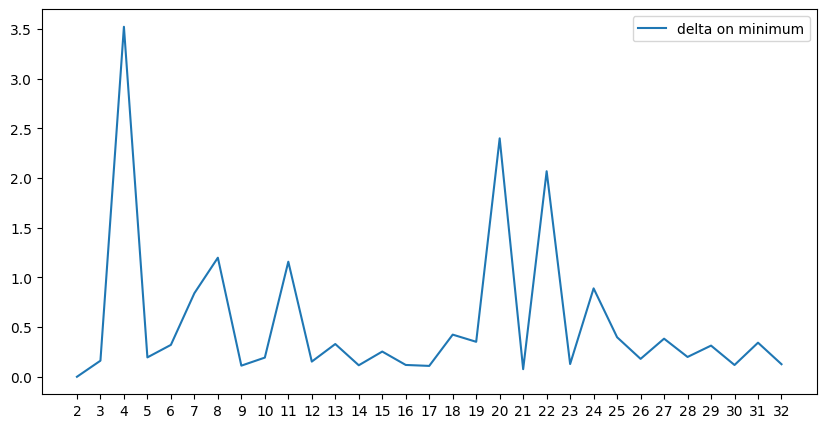

In [45]:
print(max(mean_res['delta_min']))
plt.figure(figsize=(10, 5))
plt.xticks(ticks=x)

plt.plot(mean_res["delta_min"])
plt.legend(["delta on minimum"])
# mean_res.plot()

7.243021660503501e-06


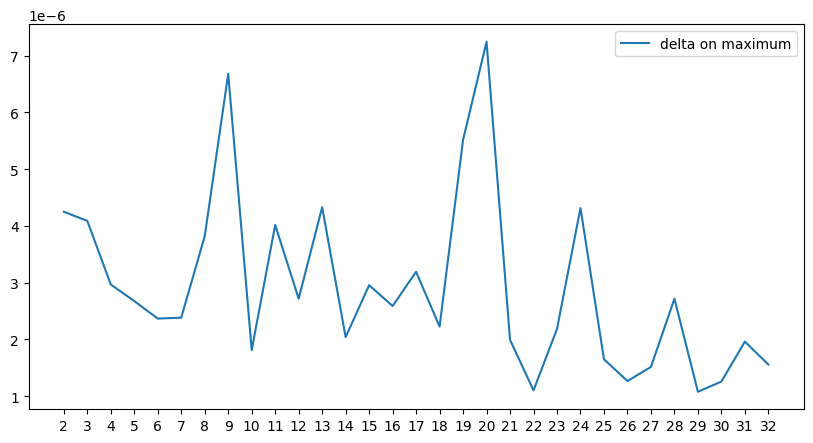

In [46]:
print(max(mean_res['delta_max']))
plt.figure(figsize=(10, 5))
plt.xticks(ticks=x)
plt.plot(mean_res["delta_max"])
plt.legend(["delta on maximum"])

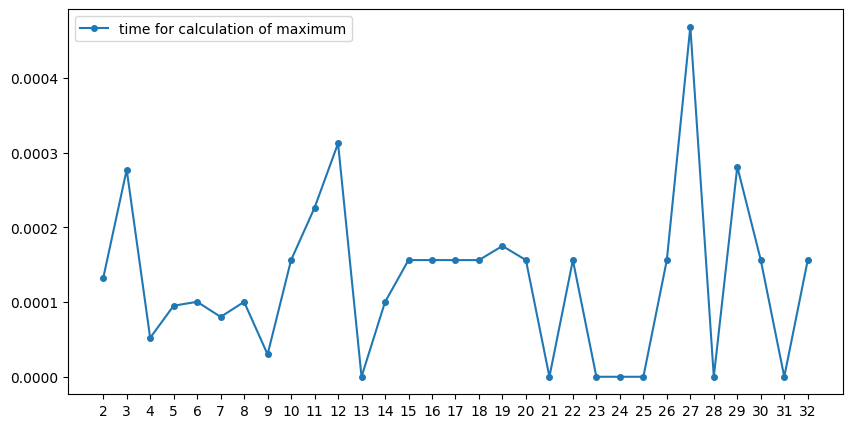

In [47]:
plt.figure(figsize=(10, 5))
plt.xticks(ticks=x)
plt.plot(mean_res['value_max_time'],  marker='o',  markersize=4)
plt.legend(["time for calculation of maximum"])


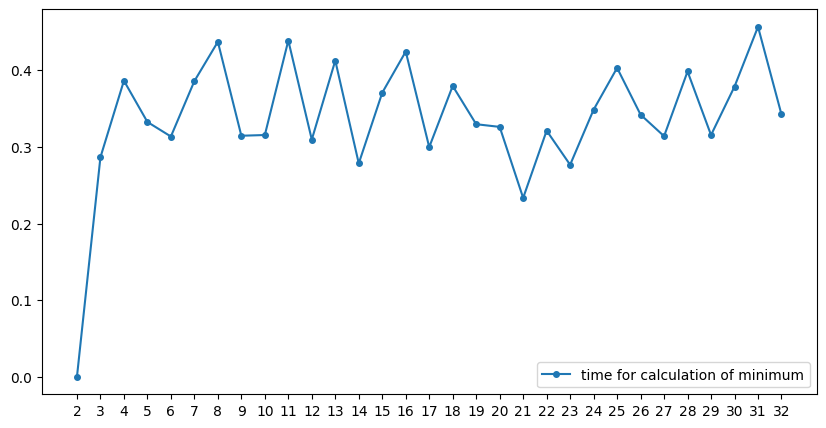

In [48]:
plt.figure(figsize=(10, 5))
plt.xticks(ticks=x)
plt.plot(mean_res['value_min_def_time'],  marker='o',  markersize=4)
plt.legend(["time for calculation of minimum"])

In [23]:
df.to_csv("data/df.csv")
res_df.to_csv("data/res_df.csv")